# **_Time Series Prediction_**

<br>

### __*Import Libraries*__
### __*[DataTable](https://datatable.readthedocs.io/en/latest/start/quick-start.html)*__

In [1]:
# Datasets
import polars as pl
import matplotlib.pyplot as plt

# Torch libraries
import torch
from torch import nn

# Data Analysis
import PyDataWiser

# Device config
device = PyDataWiser.model.pick_device(show_device=True)

Using the Graphics Card (cuda)


<br>

### __*Prepare & Show Weather Data*__

In [2]:
# Show structure of dataset
weather_raw = pl.read_csv('data/seattle-weather.csv', use_pyarrow=True)
weather_raw.head()

date,precipitation,temp_max,temp_min,wind,weather
date,f64,f64,f64,f64,str
2012-01-01,0.0,12.8,5.0,4.7,"""drizzle"""
2012-01-02,10.9,10.6,2.8,4.5,"""rain"""
2012-01-03,0.8,11.7,7.2,2.3,"""rain"""
2012-01-04,20.3,12.2,5.6,4.7,"""rain"""
2012-01-05,1.3,8.9,2.8,6.1,"""rain"""


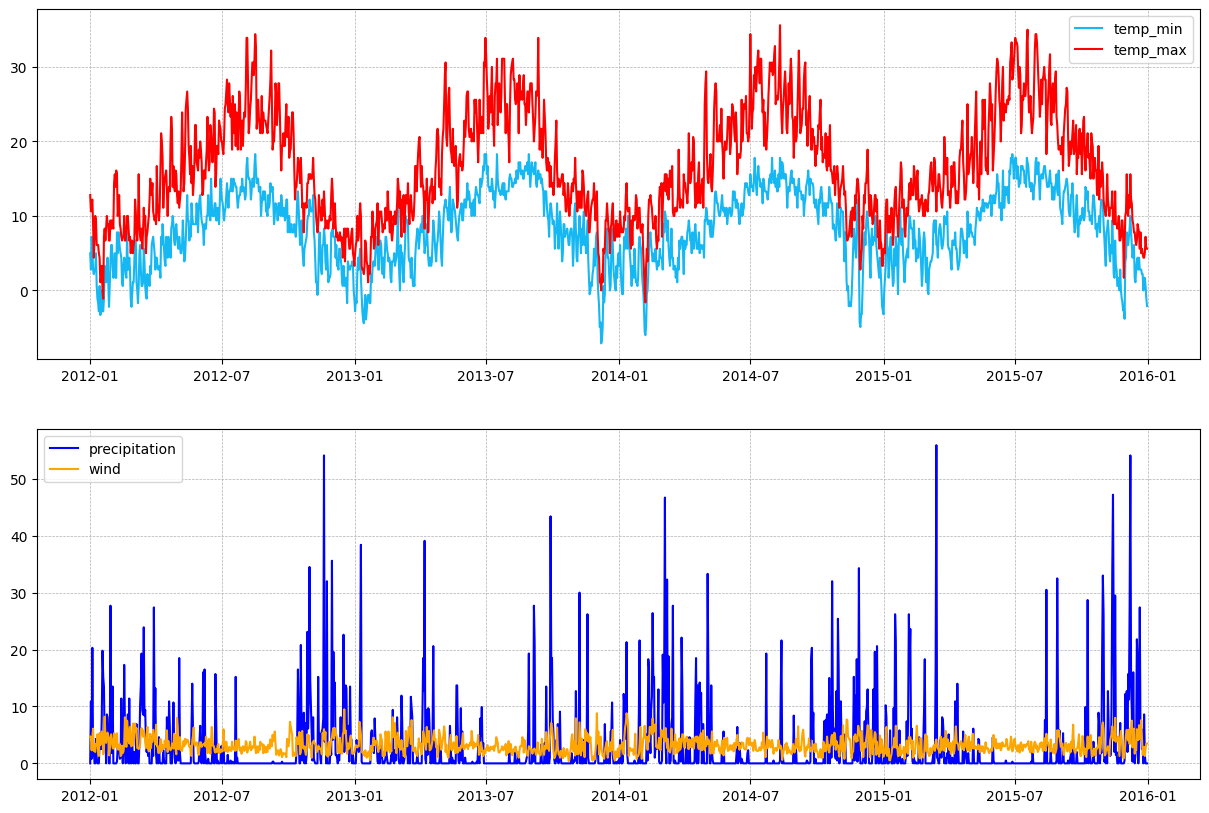

In [3]:
# Create a plot
fig_weather, axs_weather = plt.subplots(nrows=2, ncols=1, figsize=[15,10])

min_plot, = axs_weather[0].plot(weather_raw['date'], weather_raw['temp_min'],
                                label='temp_min', color='#16b8f3')
max_plot, = axs_weather[0].plot(weather_raw['date'], weather_raw['temp_max'],
                                label='temp_max', color='red')

precipitation, = axs_weather[1].plot(weather_raw['date'], weather_raw['precipitation'],
                                     label='precipitation', color='blue')
wind_plot, = axs_weather[1].plot(weather_raw['date'], weather_raw['wind'],
                                 label='wind', color='orange')

axs_weather[0].grid(linestyle='--', linewidth=0.5)
axs_weather[0].legend(handles=[min_plot, max_plot])
axs_weather[1].grid(linestyle='--', linewidth=0.5)
axs_weather[1].legend(handles=[precipitation, wind_plot])
pass

<br>

### __*Prepare dataset*__

In [4]:
Analysis = PyDataWiser.Analysis()
Analysis.update_database('weather', 'data/seattle-weather.csv')
Analysis.update_database('nasdaq', 'data/NASDAQ.csv')
Analysis.update_database('rut', 'data/RUT.csv')
Analysis.all_data()

{'database': {'weather': shape: (1_461, 6)
  ┌────────────┬───────────────┬──────────┬──────────┬──────┬─────────┐
  │ date       ┆ precipitation ┆ temp_max ┆ temp_min ┆ wind ┆ weather │
  │ ---        ┆ ---           ┆ ---      ┆ ---      ┆ ---  ┆ ---     │
  │ date       ┆ f64           ┆ f64      ┆ f64      ┆ f64  ┆ str     │
  ╞════════════╪═══════════════╪══════════╪══════════╪══════╪═════════╡
  │ 2012-01-01 ┆ 0.0           ┆ 12.8     ┆ 5.0      ┆ 4.7  ┆ drizzle │
  │ 2012-01-02 ┆ 10.9          ┆ 10.6     ┆ 2.8      ┆ 4.5  ┆ rain    │
  │ 2012-01-03 ┆ 0.8           ┆ 11.7     ┆ 7.2      ┆ 2.3  ┆ rain    │
  │ 2012-01-04 ┆ 20.3          ┆ 12.2     ┆ 5.6      ┆ 4.7  ┆ rain    │
  │ …          ┆ …             ┆ …        ┆ …        ┆ …    ┆ …       │
  │ 2015-12-28 ┆ 1.5           ┆ 5.0      ┆ 1.7      ┆ 1.3  ┆ rain    │
  │ 2015-12-29 ┆ 0.0           ┆ 7.2      ┆ 0.6      ┆ 2.6  ┆ fog     │
  │ 2015-12-30 ┆ 0.0           ┆ 5.6      ┆ -1.0     ┆ 3.4  ┆ sun     │
  │ 2015-12-31 ┆ 0.0 

<br>

### __*Create the Model*__

In [5]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # 256
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, output_size)

    def forward(self, xx):
        xx = torch.relu(self.fc1(xx))
        xx = torch.relu(self.fc2(xx))
        xx = torch.relu(self.fc3(xx))
        return self.fc4(xx)